In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc,precision_recall_curve,roc_curve,confusion_matrix
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import random
np.random.seed(10)
random.seed(10)


## His functions used to read the data

In [2]:
def aaindex(peptide,after_pca):

    amino = 'ARNDCQEGHILKMFPSTWYV-'
    matrix = np.transpose(after_pca)   # [12,21]
    encoded = np.empty([len(peptide), 12])  # (seq_len,12)
    for i in range(len(peptide)):
        query = peptide[i]
        if query == 'X': query = '-'
        query = query.upper()
        encoded[i, :] = matrix[:, amino.index(query)]

    return encoded

def rescue_unknown_hla(hla, dic_inventory):
    type_ = hla[4]
    first2 = hla[6:8]
    last2 = hla[8:]
    big_category = dic_inventory[type_]
    if not big_category.get(first2) == None:
        small_category = big_category.get(first2)
        distance = [abs(int(last2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(first2) + str(optimal)
    else:
        small_category = list(big_category.keys())
        distance = [abs(int(first2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(optimal) + str(big_category[optimal][0])

def hla_df_to_dic(hla):
    dic = {}
    for i in range(hla.shape[0]):
        col1 = hla['HLA'].iloc[i]  # HLA allele
        col2 = hla['pseudo'].iloc[i]  # pseudo sequence
        dic[col1] = col2
    return dic

def peptide_data_aaindex(peptide,after_pca):   # return numpy array [10,12,1]
    length = len(peptide)
    if length == 10:
        encode = aaindex(peptide,after_pca)
    elif length == 9:
        peptide = peptide[:5] + '-' + peptide[5:]
        encode = aaindex(peptide,after_pca)
    encode = encode.reshape(encode.shape[0], encode.shape[1], -1)
    return encode


def hla_data_aaindex(hla_dic,hla_type,after_pca):    # return numpy array [34,12,1]
    try:
        seq = hla_dic[hla_type]
    except KeyError:
        hla_type = rescue_unknown_hla(hla_type,dic_inventory)
        seq = hla_dic[hla_type]
    encode = aaindex(seq,after_pca)
    encode = encode.reshape(encode.shape[0], encode.shape[1], -1)
    return encode

def dict_inventory(inventory):
    dicA, dicB, dicC = {}, {}, {}
    dic = {'A': dicA, 'B': dicB, 'C': dicC}

    for hla in inventory:
        type_ = hla[4]  # A,B,C
        first2 = hla[6:8]  # 01
        last2 = hla[8:]  # 01
        try:
            dic[type_][first2].append(last2)
        except KeyError:
            dic[type_][first2] = []
            dic[type_][first2].append(last2)

    return dic

def construct_aaindex(ori,hla_dic,after_pca):
    series = []
    for i in range(ori.shape[0]):
        peptide = ori['peptide'].iloc[i]
        hla_type = ori['HLA'].iloc[i]
        immuno = np.array(ori['immunogenicity'].iloc[i]).reshape(1,-1)   # [1,1]

        encode_pep = peptide_data_aaindex(peptide,after_pca)    # [10,12]

        encode_hla = hla_data_aaindex(hla_dic,hla_type,after_pca)   # [46,12]
        series.append((encode_pep, encode_hla, immuno))
    return series

def pull_peptide_aaindex(dataset):
    result = np.empty([len(dataset),10,12,1])
    for i in range(len(dataset)):
        result[i,:,:,:] = dataset[i][0]
    return result

def pull_hla_aaindex(dataset):
    result = np.empty([len(dataset),46,12,1])
    for i in range(len(dataset)):
        result[i,:,:,:] = dataset[i][1]
    return result


def pull_label_aaindex(dataset):
    col = [item[2] for item in dataset]
    result = [0 if item == 'Negative' else 1 for item in col]
    result = np.expand_dims(np.array(result),axis=1)
    return result


## My functions

In [3]:
def load_training_and_validataion_dataset(path_to_partitions,train_splits):
    import random
    training_partions = random.sample(range(10),train_splits)
    validation_partions = [i for i in range(10) if i not in training_partions]

    # path_to_partitions = "../data/partitions"
    partitions = []
    for file in os.listdir(path_to_partitions):
        path_to_file = os.path.join(path_to_partitions,file)
        data = pd.read_csv(path_to_file,sep="\t",names=["peptide","label","HLA"])
        partitions.append(data)
    training_df = pd.concat([partitions[i] for i in training_partions])
    validation_df = pd.concat([partitions[i] for i in validation_partions])
    return training_df, validation_df

def retrieve_information_from_df(data_split,entire_df):
    potential = []
    immunogenicity = []
    tested = []
    responded = []
    for i,row in data_split.iterrows():
        peptide, HLA = row["peptide"], row['HLA']
        original_entry = entire_df[(entire_df['peptide']==peptide) & (entire_df['HLA'] == HLA)]
        assert len(original_entry) == 1
        potential.append(float(original_entry['potential']))
        immunogenicity.append(original_entry['immunogenicity'].values[0])
        tested.append(int(original_entry['test']))
        responded.append(int(original_entry['respond']))
     
    data_split['potential'] = potential
    data_split['immunogenicity'] = immunogenicity
    data_split['test'] = tested
    data_split['respond'] = responded

    return data_split  

## Loading the data

The strategy used by the paper to load the data

In [4]:
# Loading the dataset
# after_pca = np.loadtxt('../DeepImmuno//reproduce/data/after_pca.txt')
# ori = pd.read_csv('../DeepImmuno//reproduce/data/remove0123_sample100.csv')
# ori = ori.sample(frac=1, replace=False).set_index(pd.Index(np.arange(ori.shape[0])))
# hla = pd.read_csv('../DeepImmuno/reproduce/data/hla2paratopeTable_aligned.txt', sep='\t')
# hla_dic = hla_df_to_dic(hla)
# inventory = list(hla_dic.keys())
# dic_inventory = dict_inventory(inventory)
# dataset = construct_aaindex(ori, hla_dic, after_pca)
# input1 = pull_peptide_aaindex(dataset)
# input2 = pull_hla_aaindex(dataset)
# label = pull_label_aaindex(dataset)

# input1 = input1.astype('float32')
# input2 = input2.astype('float32')
# label = label.astype('float32')

# array = np.arange(len(dataset))
# train_index = np.random.choice(array,int(len(dataset)*0.9),replace=False)
# valid_index = [item for item in array if item not in train_index]

# input1 = input1.astype('float32')
# input2 = input2.astype('float32')
# label = label.astype('float32')

# # Reshaped data
# input1 = pull_peptide_aaindex(dataset).reshape(-1,1,10,12)
# input2 = pull_hla_aaindex(dataset).reshape(-1,1,46,12)
# label = pull_label_aaindex(dataset)


# peptide_train, peptide_val = input1[train_index], input1[valid_index]
# HLA_train, HLA_val = input2[train_index], input2[valid_index]
# label_train, label_val = label[train_index], label[valid_index]


Correct partioning of the data

In [5]:
after_pca = np.loadtxt('../DeepImmuno//reproduce/data/after_pca.txt')
hla = pd.read_csv('../DeepImmuno/reproduce/data/hla2paratopeTable_aligned.txt', sep='\t')
hla_dic = hla_df_to_dic(hla)
inventory = list(hla_dic.keys())
dic_inventory = dict_inventory(inventory)

entire_df = pd.read_csv('../data/deep_immuno_2.csv')
# Taking samples from the correct partitions
training_df, validation_df = load_training_and_validataion_dataset(path_to_partitions="../data/partitions",train_splits=8)

# Creating the training dataframe
training_df_entire = retrieve_information_from_df(training_df,entire_df)
training_df_entire = training_df_entire.sample(frac=1, random_state=1).reset_index(drop=True)
# Creating the validation dataframe

validation_df_entire = retrieve_information_from_df(validation_df,entire_df)
validation_df_entire = validation_df_entire.sample(frac=1, random_state=1).reset_index(drop=True)


training_dataset_encoded = construct_aaindex(training_df, hla_dic, after_pca)
peptide_train = pull_peptide_aaindex(training_dataset_encoded)
HLA_train = pull_hla_aaindex(training_dataset_encoded)
label_train = pull_label_aaindex(training_dataset_encoded)


val_dataset_encoded = construct_aaindex(validation_df, hla_dic, after_pca)
peptide_val = pull_peptide_aaindex(val_dataset_encoded)
HLA_val = pull_hla_aaindex(val_dataset_encoded)
label_val = pull_label_aaindex(val_dataset_encoded)

peptide_train = peptide_train.reshape(-1,1,10,12).astype('float32')
HLA_train = HLA_train.reshape(-1,1,46,12).astype('float32')
label_train = label_train.astype('float32')

peptide_val = peptide_val.reshape(-1,1,10,12).astype('float32')
HLA_val = HLA_val.reshape(-1,1,46,12).astype('float32')
label_val = label_val.astype('float32')



## Definning the model

In [6]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d

In [7]:
def compute_conv_dim(dim_size,kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)
compute_conv_dim(10,2,0,1)

9

In [8]:

# hyperameters of the model

peptide_input_channels = peptide_train.shape[1]
peptide_input_height = peptide_train.shape[2]
peptide_input_width = peptide_train.shape[3]

hla_input_channels = HLA_train.shape[1]
hla_input_height = HLA_train.shape[2]
hla_input_width = HLA_train.shape[3]

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Convelution of peptide
        self.conv1_peptide = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(2,12),
                            stride=1,
                            padding=0)
        
        self.BatchNorm_conv1_peptides = BatchNorm2d(16) # Output channels from the previous layer
        self.conv2_peptide = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(2,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_peptides = BatchNorm2d(32) # Output channels from the previous layer
        self.maxpool1_peptide = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        # Convelution of HLA
        self.conv1_HLA = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(15,12),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv1_HLA = BatchNorm2d(16) # Output channels from the previous layer
        self.maxpool1_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
        
        self.conv2_HLA = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(9,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_peptides = BatchNorm2d(32) # Output channels from the previous layer
        self.maxpool2_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        # Denselayer
        self.l_out = Linear(in_features=256,
                            out_features=1,
                            bias=False)
        self.drop_out = nn.Dropout(p=0.2)


    def forward(self, peptide, HLA): # x.size() = [batch, channel, height, width]

        # Encoding the peptide
        peptide = self.conv1_peptide(peptide)
        peptide = self.BatchNorm_conv1_peptides(peptide)
        peptide = relu(peptide)
        peptide = self.conv2_peptide(peptide)
        peptide = self.BatchNorm_conv2_peptides(peptide)
        peptide = relu(peptide)
        peptide = self.maxpool1_peptide(peptide)
        peptide = torch.flatten(peptide,start_dim=1)

        # Encoding the HLA
        HLA = self.conv1_HLA(HLA)
        HLA = self.BatchNorm_conv1_HLA(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool1_HLA(HLA)
        HLA = self.conv2_HLA(HLA)
        HLA = self.BatchNorm_conv2_peptides(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool2_HLA(HLA)
        HLA = torch.flatten(HLA,start_dim=1)


        # Combining the output
        combined_input = torch.cat((peptide, HLA), 1)
        x = self.l_out(combined_input)
        x = self.drop_out(x)
        x = nn.Sigmoid()(x)
        return x

net = Net()
print(net)

Net(
  (conv1_peptide): Conv2d(1, 16, kernel_size=(2, 12), stride=(1, 1))
  (BatchNorm_conv1_peptides): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_peptide): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1))
  (BatchNorm_conv2_peptides): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1_peptide): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv1_HLA): Conv2d(1, 16, kernel_size=(15, 12), stride=(1, 1))
  (BatchNorm_conv1_HLA): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1_HLA): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2_HLA): Conv2d(16, 32, kernel_size=(9, 1), stride=(1, 1))
  (maxpool2_HLA): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (l_out): Linear(in_features=256, out_features=1, bias=False)
  (drop_out): Dropout(p=0

In [9]:
peptide_random = np.random.normal(0,1, (128, 1, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (128, 1, 46, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
output = net(peptide_random,HLA_random)

## Creating testing and validataion datasets

## Training and evaluating the model

In [10]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)

In [11]:
batch_size = 16
epochs = 100

peptide_train_loader = list(DataLoader(peptide_train,batch_size=batch_size))
HLA_train_loader = list(DataLoader(HLA_train,batch_size=batch_size))
label_train_loader = list(DataLoader(label_train,batch_size=batch_size))

peptide_val_loader = list(DataLoader(peptide_val,batch_size=batch_size))
HLA_val_loader = list(DataLoader(HLA_val,batch_size=batch_size))
label_val_loader = list(DataLoader(label_val,batch_size=batch_size))

losses = []
cur_loss = 0

train_acc = []
valid_acc = []

train_prediction_pr_epoch = []
train_labels_pr_epoch = []

valid_prediction_pr_epoch = []
valid_labels_pr_epoch = []

for epoch in range(epochs):
    ## Firstly the model is trained
    cur_loss = 0
    net.train()
    for i in range(len(peptide_train_loader)):
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(peptide_train_loader[i],HLA_train_loader[i])
        batch_loss = criterion(outputs, label_train_loader[i])
        batch_loss.backward()
        optimizer.step()
        cur_loss += batch_loss
    losses.append(cur_loss / batch_size)


    ## The model is then evalauted on both the training and valdition dataset
    net.eval()
    train_preds, train_targs = [], []
    train_preds_labels = []
    val_preds, val_targs = [], []
    val_preds_labels = []
    for j in range(len(peptide_train_loader)):
        output = net(peptide_train_loader[j],HLA_train_loader[j])
        train_targs += list(label_train_loader[j].numpy())
        train_preds += list(output.data.numpy())
        train_preds_labels += [np.array([round(x[0],0)],dtype='float32') for x in output.data.numpy()]

    
    for k in range(len(peptide_val_loader)):
        output = net(peptide_val_loader[k],HLA_val_loader[k])
        val_targs += list(label_val_loader[k].numpy())
        val_preds_labels += [np.array([round(x[0],0)],dtype='float32') for x in output.data.numpy()]
        val_preds += list(output.data.numpy())
    
    train_acc_cur = accuracy_score(train_targs, train_preds_labels)
    valid_acc_cur = accuracy_score(val_targs, val_preds_labels)


    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)

    train_prediction_pr_epoch.append(train_preds)
    train_labels_pr_epoch.append(train_targs)

    valid_prediction_pr_epoch.append(val_preds)
    valid_labels_pr_epoch.append(val_targs)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))


Epoch  1 : Train Loss 6.638760 , Train acc 0.588949, Valid acc 0.579078
Epoch 11 : Train Loss 4.566402 , Train acc 0.742724, Valid acc 0.740349
Epoch 21 : Train Loss 4.078440 , Train acc 0.738833, Valid acc 0.733499
Epoch 31 : Train Loss 3.773333 , Train acc 0.631595, Valid acc 0.628269
Epoch 41 : Train Loss 3.463874 , Train acc 0.550350, Valid acc 0.556663
Epoch 51 : Train Loss 3.174637 , Train acc 0.514864, Valid acc 0.517435
Epoch 61 : Train Loss 2.956905 , Train acc 0.491362, Valid acc 0.496887
Epoch 71 : Train Loss 2.779931 , Train acc 0.468949, Valid acc 0.477584
Epoch 81 : Train Loss 2.616955 , Train acc 0.465214, Valid acc 0.471357
Epoch 91 : Train Loss 2.550762 , Train acc 0.464591, Valid acc 0.471357


(Text(0.5, 0, 'epochs'), Text(0, 0.5, 'Acc'))

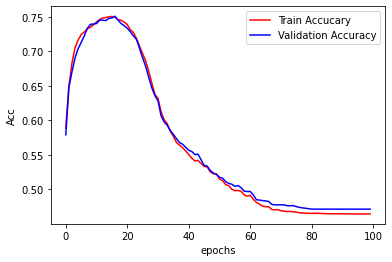

In [12]:
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('epochs'), plt.ylabel('Acc')

In [13]:
val_predictions = np.array(valid_prediction_pr_epoch)
val_labels = np.array(valid_labels_pr_epoch)
val_predictions = val_predictions.reshape(val_predictions.shape[0],val_predictions.shape[1])
val_labels = val_labels.reshape(val_labels.shape[0],val_labels.shape[1])

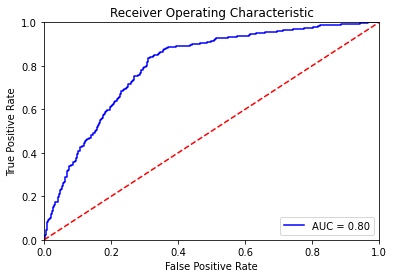

In [17]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

best_epoch_model = np.argmax(valid_acc)
fpr, tpr, threshold = metrics.roc_curve(val_labels[best_epoch_model],val_predictions[best_epoch_model])
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

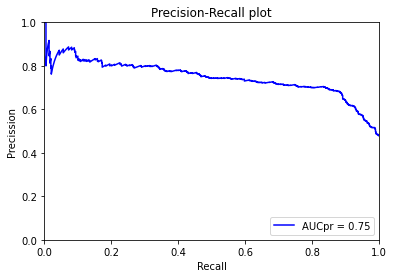

In [18]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(val_labels[best_epoch_model],val_predictions[best_epoch_model])
roc_auc = metrics.auc(recall, precision)
plt.title('Precision-Recall plot')
plt.plot(recall, precision, 'b', label = 'AUCpr = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precission')
plt.xlabel('Recall')
plt.show()


In [16]:
val_labels[best_epoch_model],val_predictions[best_epoch_model]

(array([0., 0., 0., ..., 1., 1., 1.], dtype=float32),
 array([0.6505416 , 0.7211637 , 0.61729807, ..., 0.9425862 , 0.85111314,
        0.8378202 ], dtype=float32))